# Deep Fusion

In [1]:
import tensorflow as tf

parameters:

In [2]:
fileName = "..\\data\\c100f.txt"

# --- choose one of this configurations ---
# config = 'huawei_w'
# config = 'huawei_v'
config = 'mnist'

if config == 'mnist':
    test_is_image = False
    imgSize = 28
    nChannels = 1
    nClasses = 10
    n1 = 512
    n2 = 128
elif config == 'huawei_w': # fit weights
    test_is_image = False
    imgSize = 7
    nChannels = 8
    nClasses = 8
    n1 = 512
    n2 = 128
elif config == 'huawei_v': # fit whole patches
    test_is_image = True
    imgSize = 7
    nChannels = 8
    nClasses = 49
    n1 = 512
    n2 = 256
    
    
train_batch_size = 100
test_batch_size = 100
nEpochs = 50
nDispIter = 100
normalizeOutput = False
dropout = 1.0

Import huawei data:

In [3]:
import numpy as np

xd = []
yd = []
zd = []
with open(fileName) as f:
    for line in f:
        nrois, w, h = [int(x) for x in line.split()]
        xr = []
        for _ in range(nrois):
            xr.extend([float(x) for x in next(f).split()])
        xd.append(xr)
        yd.append([float(x) for x in next(f).split()])
        zd.append([float(x) for x in next(f).split()])
        
nDataSamples = len(yd)

Import mnist data

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Getting a batch from train data

In [5]:
import random

def get_batch_huawei(batchSize, flg = 'w'):
    sample = random.sample(range(nDataSamples), batchSize)
    xxd = [xd[i] for i in sample]
    yyd = [yd[i] for i in sample]
    zzd = [zd[i] for i in sample]
    if flg == 'w':
        return [xxd, zzd]
    else:
        return [xxd, yyd]

def get_batch(batchSize):
    if config == 'huawei_w': return get_batch_huawei(batchSize, 'w')
    elif config == 'huawei_v': return get_batch_huawei(batchSize, 'v')
    elif config == 'mnist': return mnist.train.next_batch(batchSize)
    

### Define placeholders

In [6]:
x = tf.placeholder(tf.float32, [None, imgSize*imgSize*nChannels])
y = tf.placeholder(tf.float32, [None, nClasses])

### Weight initialization
To create this model, we're going to need to create a lot of weights and biases. One should generally initialize weights with a small amount of noise for symmetry breaking, and to prevent 0 gradients. Since we're using ReLU neurons, it is also good practice to initialize them with a slightly positive initial bias to avoid "dead neurons". Instead of doing this repeatedly while we build the model, let's create two handy functions to do it for us.

In [7]:
def weight_variable(_name, _shape):
    return tf.get_variable(name = _name, shape = _shape, initializer=tf.contrib.layers.xavier_initializer())
    #return tf.Variable(tf.truncated_normal(shape, stddev=0.1))

def bias_variable(_name, _shape):
    return tf.get_variable(name = _name, shape = _shape, initializer=tf.contrib.layers.xavier_initializer())
    #return tf.Variable(tf.constant(0.1, shape=shape))

### Dropout

To reduce overfitting, we will apply dropout. We create a placeholder for the probability that a neuron's output is kept during dropout. This allows us to turn dropout on during training, and turn it off during testing. TensorFlow's tf.nn.dropout op automatically handles scaling neuron outputs in addition to masking them, so dropout just works without any additional scaling.

In [8]:
keep_prob = tf.placeholder(tf.float32)

### First fully-connected layer

In [9]:
W_fc1 = weight_variable("W1", [imgSize * imgSize * nChannels, n1])
b_fc1 = bias_variable("b1", [n1])

x_flat = tf.reshape(x, [-1, imgSize * imgSize * nChannels])
h_fc1 = tf.nn.relu(tf.add(tf.matmul(x_flat, W_fc1), b_fc1))
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

### Second fully-connected layer

In [10]:
W_fc2 = weight_variable("W2", [n1, n2])
b_fc2 = bias_variable("b2", [n2])

h_fc2 = tf.nn.relu(tf.add(tf.matmul(h_fc1_drop, W_fc2), b_fc2))
h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

### Readout Layer
Calculate the last layer and normalize the output so that the sum of all weights is 1.0

In [11]:
W_fc3 = weight_variable("W3", [n2, nClasses])
b_fc3 = bias_variable("b3", [nClasses])

v = tf.add(tf.matmul(h_fc2_drop, W_fc3), b_fc3)
if normalizeOutput:
    y_res = tf.div(v, tf.reduce_sum(v))
    #y_res = tf.nn.l2_normalize(u_res, 1)
else:
    y_res = v

### Train and eval

In [12]:
def test(print_results = False):
    correct_prediction = tf.equal(tf.argmax(y_res, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    xt, yt = get_batch(test_batch_size)
    acc, res = sess.run([accuracy, y_res], feed_dict={x:xt, y:yt, keep_prob: 1.0})
    print("Accuracy:", acc)
    if print_results:
        np.set_printoptions(precision=2)
        for i in range(test_batch_size):
            print('real: ', yt[i])
            print('predicted: ', res[i])

In [13]:
def graphical_test(is_image = test_is_image):
    from matplotlib import pyplot as plt
    xt, yt = get_batch(test_batch_size)
    rt = sess.run(y_res, feed_dict={x:xt, y:yt, keep_prob: 1.0})
    for i in range(test_batch_size):
        src = np.asarray(yt[i])
        res = np.asarray(rt[i])
        if is_image:
            src = src.reshape(imgSize, imgSize)
            res = res.reshape(imgSize, imgSize)
        fig = plt.figure()
        a=fig.add_subplot(1,2,1)
        if is_image: plt.imshow(src, cmap='gray')
        else: plt.plot(src)
        a.set_title('src')
        a=fig.add_subplot(1,2,2)
        if is_image: plt.imshow(res, cmap='gray')
        else: plt.plot(res)
        a.set_title('output')
        plt.show()

In [14]:
loss = tf.reduce_mean(tf.losses.mean_squared_error(y_res, y))
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_res, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

### Session

In [15]:
sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
sess.run(init)

In [16]:
np.set_printoptions(precision=2)

iterations = round(nDataSamples / train_batch_size)
for e in range(nEpochs):
    print('Epoch ', e)
    loss_sum = 0.0
    for it in range(iterations):
        xx, yy = get_batch(train_batch_size)
        _, l = sess.run([train_step, loss], feed_dict={x: xx, y: yy, keep_prob: dropout})
        loss_sum += l
        if it % nDispIter == 0:
            print("loss_avg: ", loss_sum / (it+1))
    test()

Epoch  0
loss_avg:  0.258893191814
loss_avg:  0.0792728942072
loss_avg:  0.0610462472454
loss_avg:  0.0520973694743
Accuracy: 0.95
Epoch  1
loss_avg:  0.0251258723438
loss_avg:  0.0268300147082
loss_avg:  0.024582303801
loss_avg:  0.0235603816523
Accuracy: 0.92
Epoch  2
loss_avg:  0.0237599052489
loss_avg:  0.0192250105562
loss_avg:  0.0187503641647
loss_avg:  0.018271193196
Accuracy: 0.98
Epoch  3
loss_avg:  0.0160795412958
loss_avg:  0.0156661800966
loss_avg:  0.0153136401442
loss_avg:  0.0151090909482
Accuracy: 0.98
Epoch  4
loss_avg:  0.0146373072639
loss_avg:  0.0139007496804
loss_avg:  0.013463069606
loss_avg:  0.0132043519076
Accuracy: 0.96
Epoch  5
loss_avg:  0.0148392738774
loss_avg:  0.0122980671926
loss_avg:  0.0120279150111
loss_avg:  0.0119209491085
Accuracy: 0.99
Epoch  6
loss_avg:  0.0121116610244
loss_avg:  0.0106441109847
loss_avg:  0.0106052608039
loss_avg:  0.0105599433329
Accuracy: 0.95
Epoch  7
loss_avg:  0.0109554575756
loss_avg:  0.00967608248391
loss_avg:  0.009

### Test

Accuracy: 1.0
real:  [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
predicted:  [ 0.01  0.02  0.95  0.01  0.01 -0.   -0.01 -0.   -0.02 -0.01]
real:  [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
predicted:  [ 0.02  1.04 -0.03  0.02  0.   -0.02 -0.01 -0.01 -0.02  0.  ]
real:  [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
predicted:  [-0.    0.   -0.02 -0.02  1.06  0.01 -0.01 -0.01 -0.02  0.  ]
real:  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
predicted:  [ 0.01  0.01  0.01 -0.02  0.04  0.02 -0.01 -0.04 -0.02  1.  ]
real:  [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
predicted:  [  2.02e-02   1.94e-02  -3.40e-02  -1.60e-02   1.07e+00  -6.72e-03
   6.03e-03  -7.92e-02  -4.27e-04  -3.94e-02]
real:  [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
predicted:  [  7.13e-03   8.78e-03   6.31e-03   1.72e-02   1.34e-02   1.03e-02
   3.27e-04   8.80e-01   4.12e-02   4.74e-02]
real:  [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
predicted:  [ 0.02  0.03  1.02  0.06 -0.03 -0.02 -0.04 -0.02  0.02 -0.04]
real:  [ 0.  0.  0.  0.

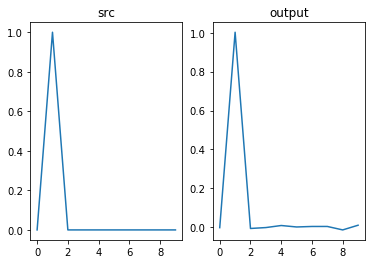

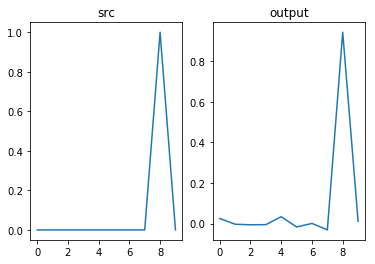

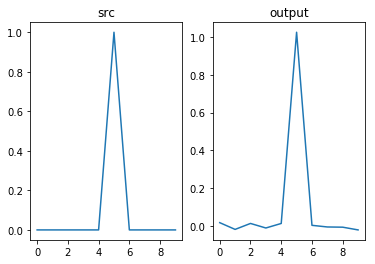

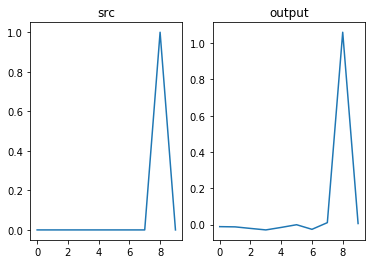

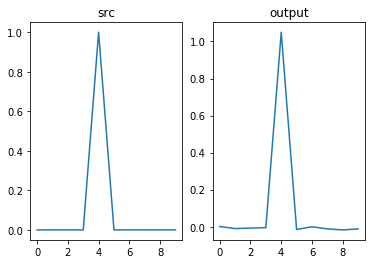

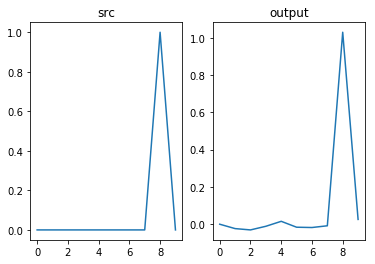

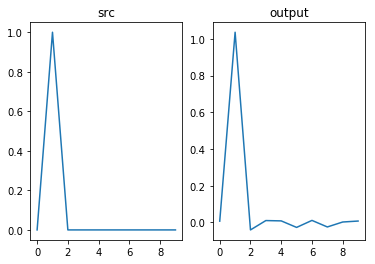

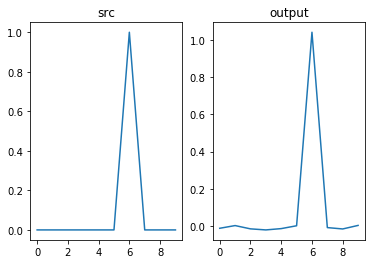

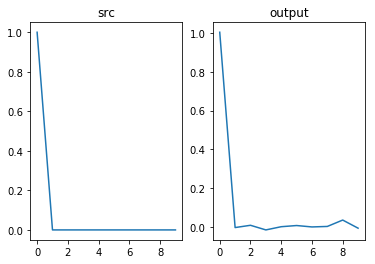

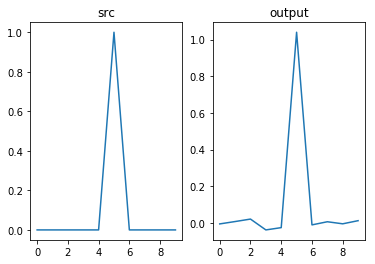

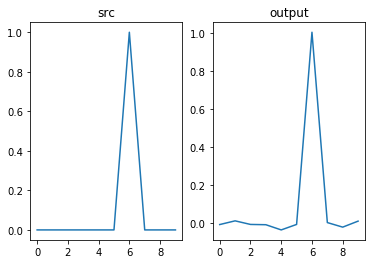

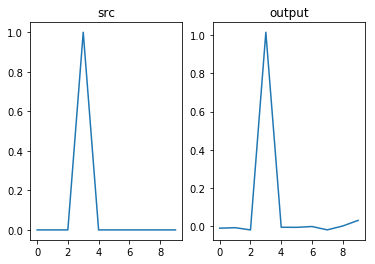

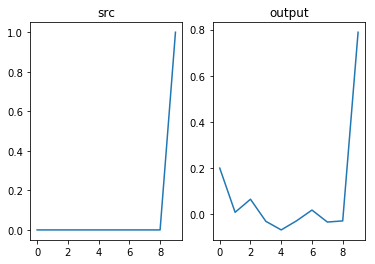

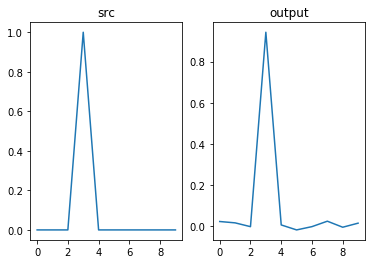

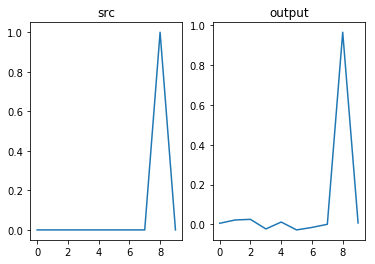

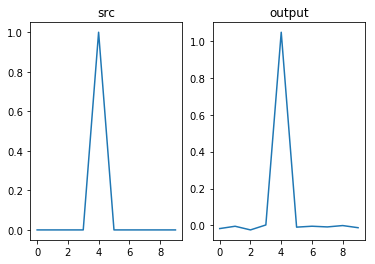

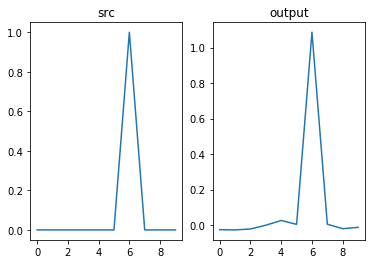

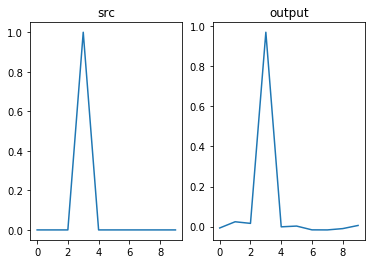

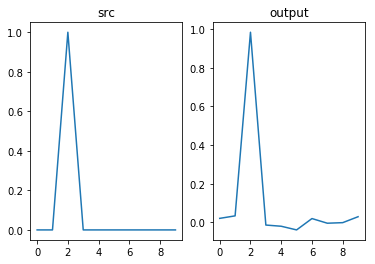

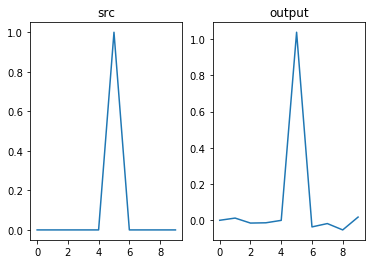

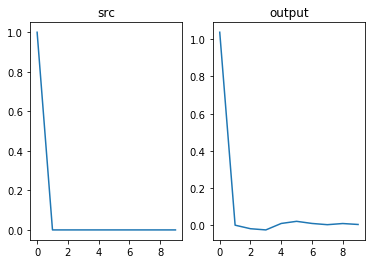

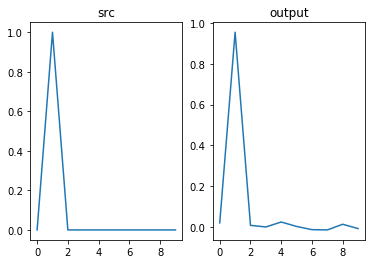

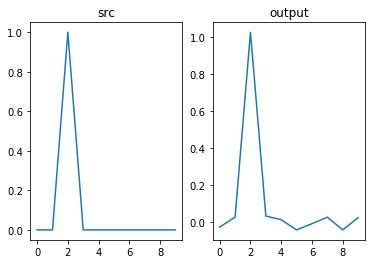

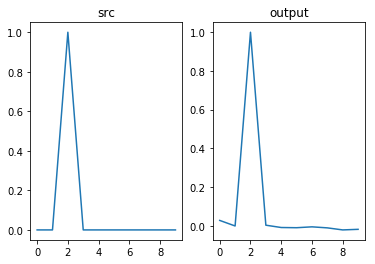

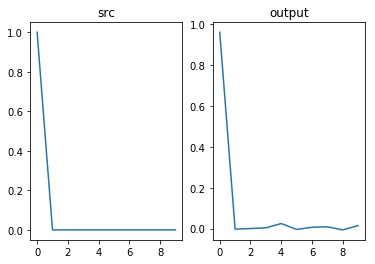

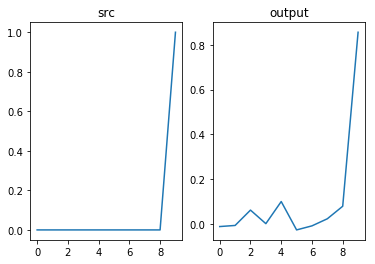

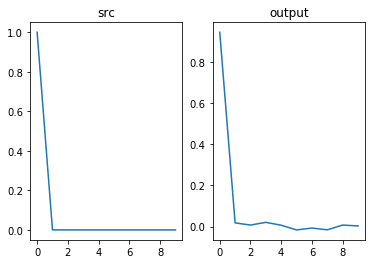

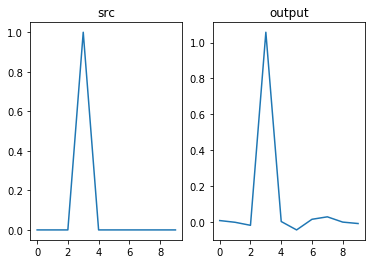

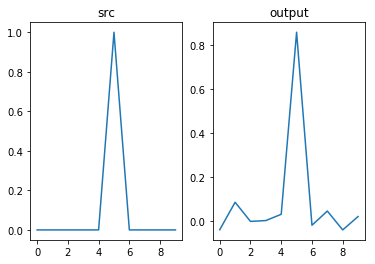

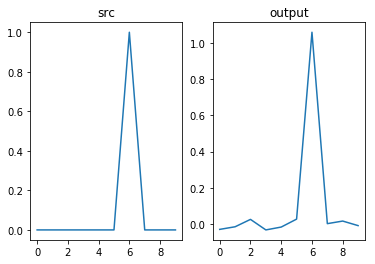

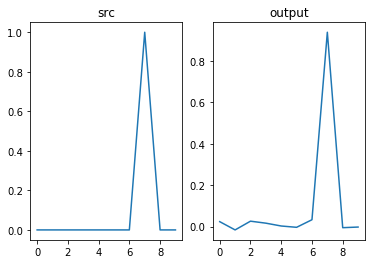

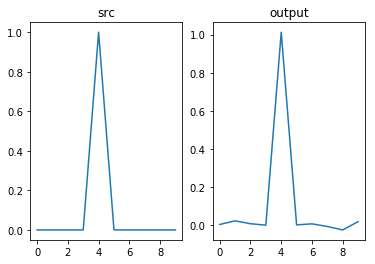

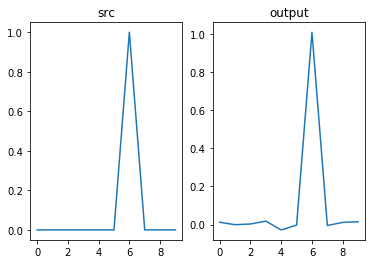

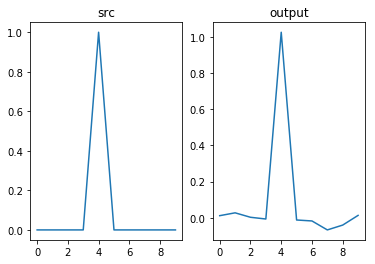

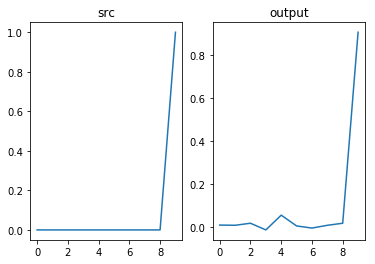

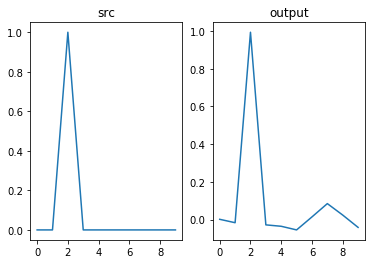

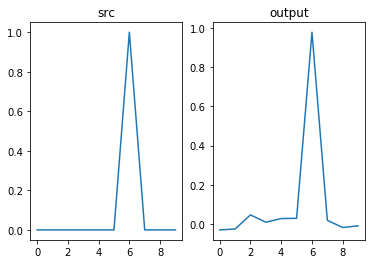

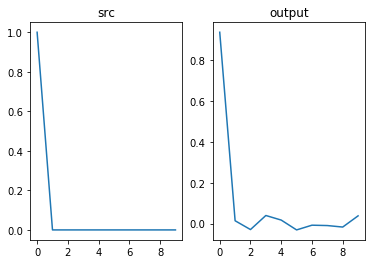

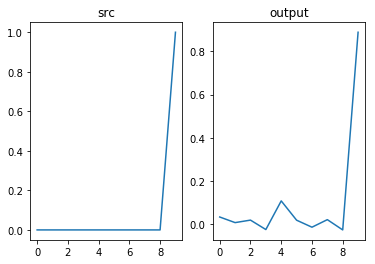

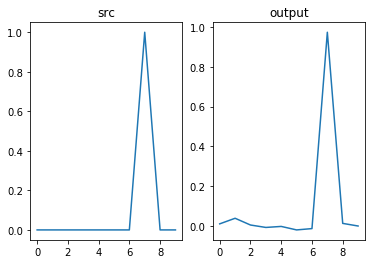

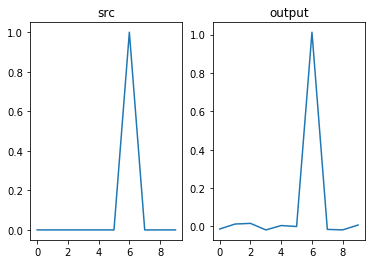

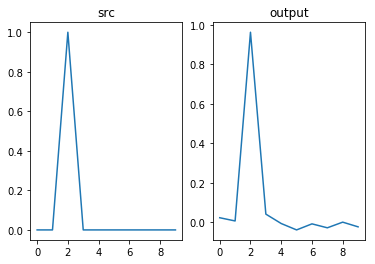

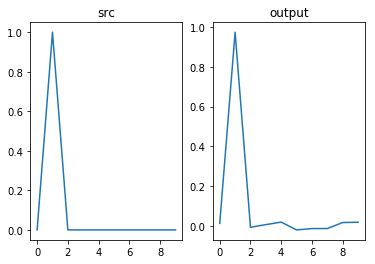

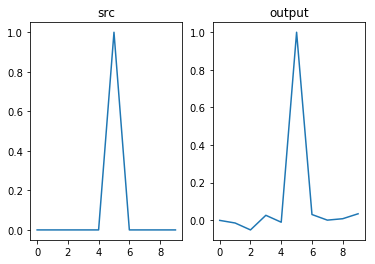

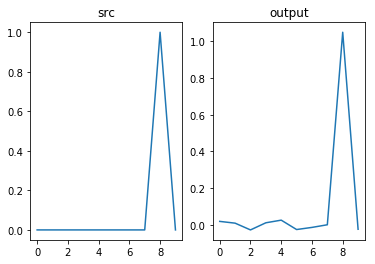

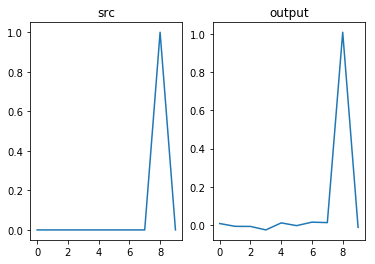

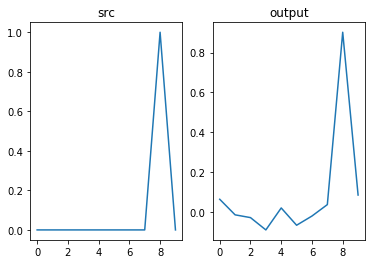

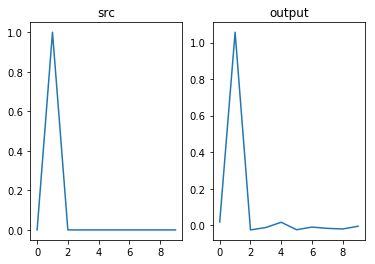

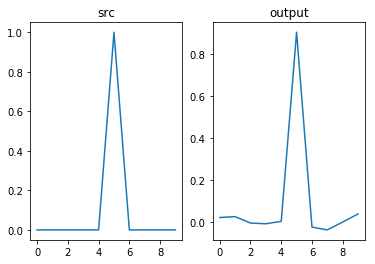

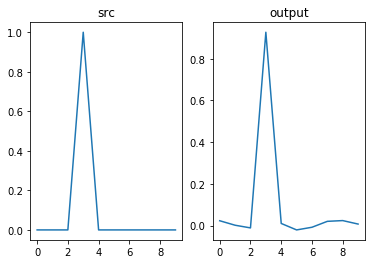

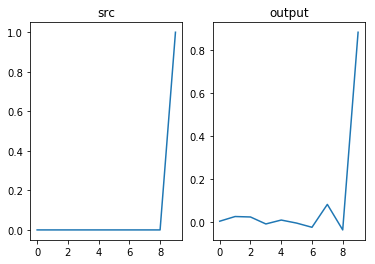

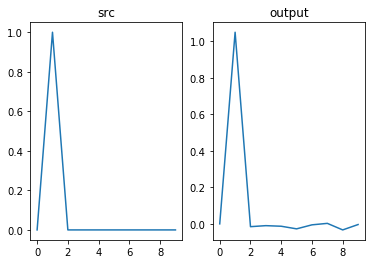

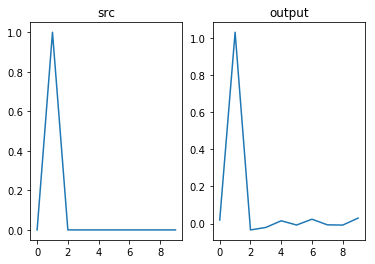

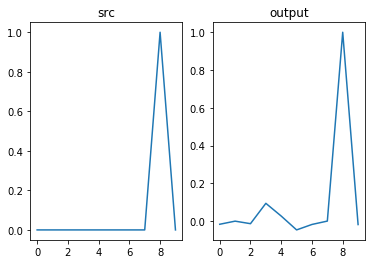

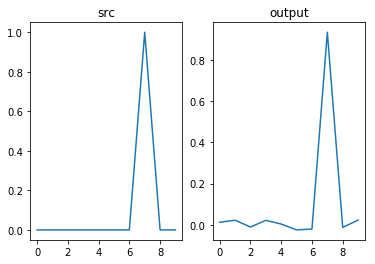

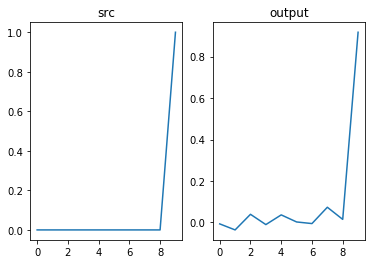

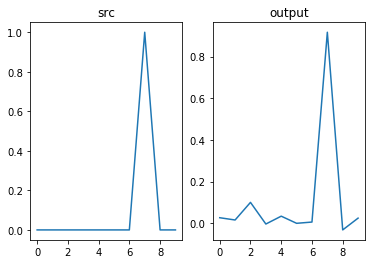

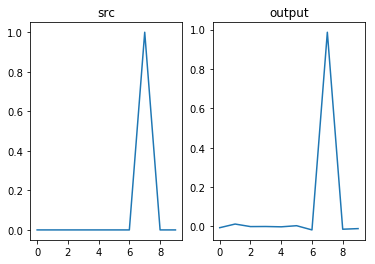

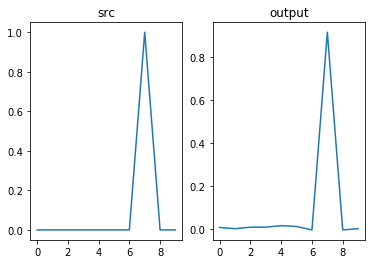

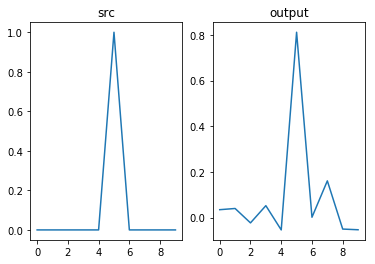

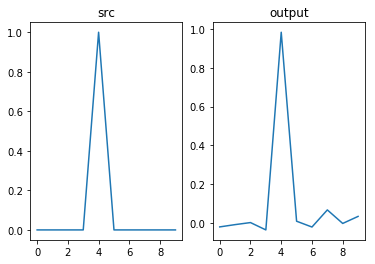

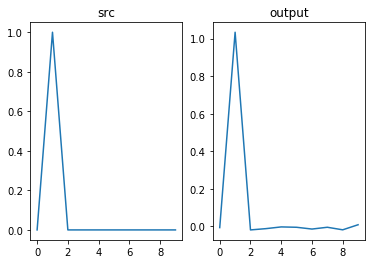

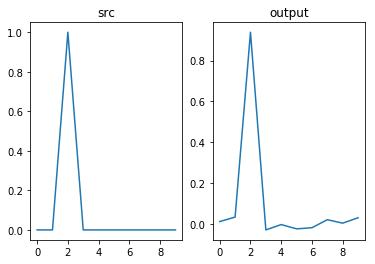

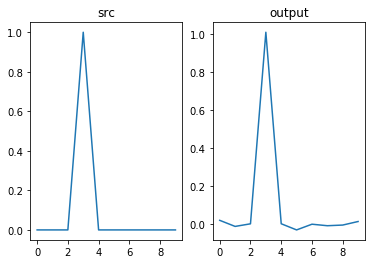

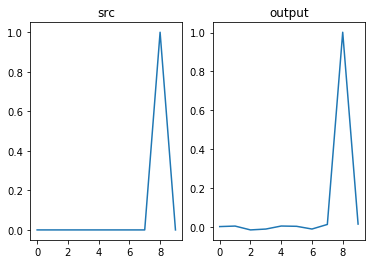

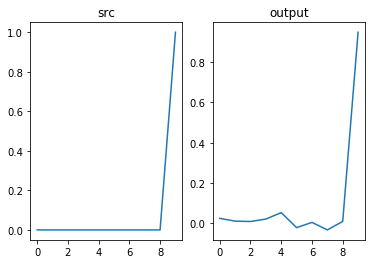

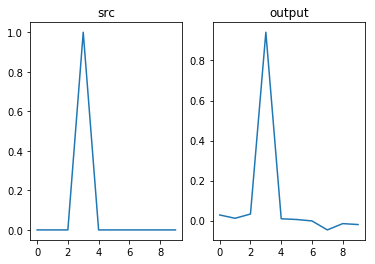

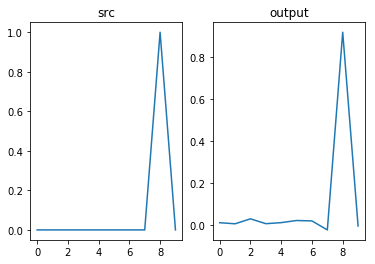

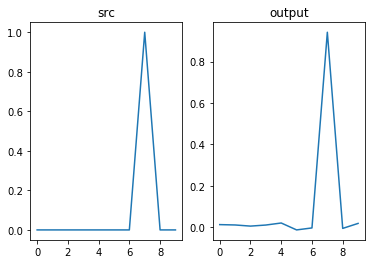

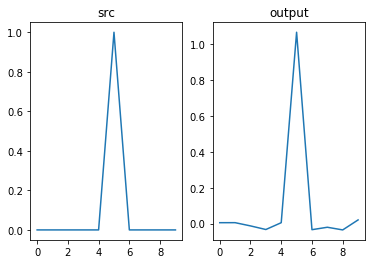

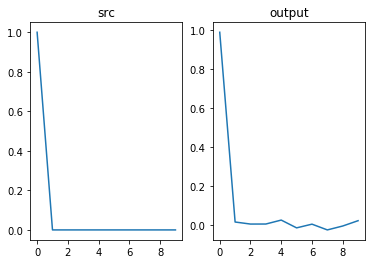

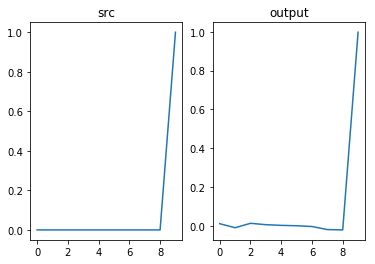

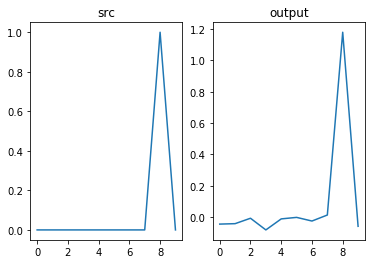

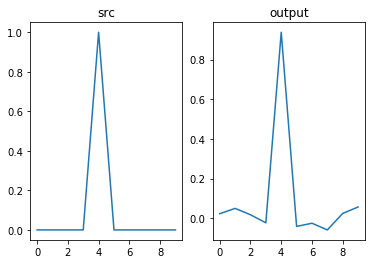

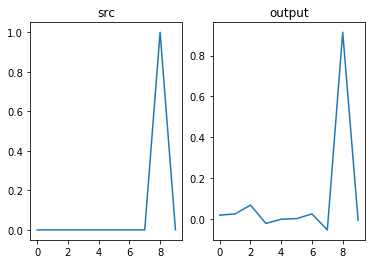

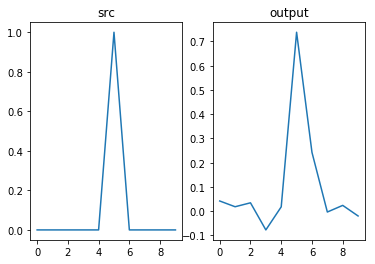

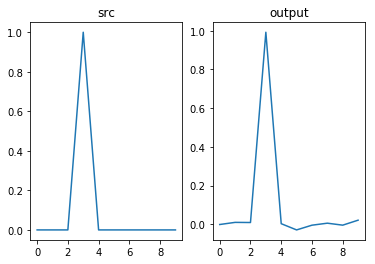

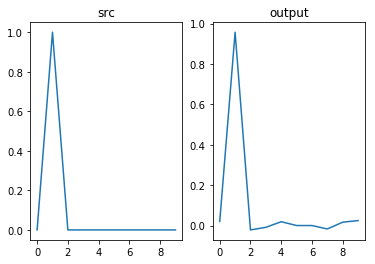

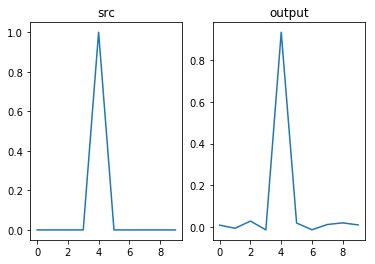

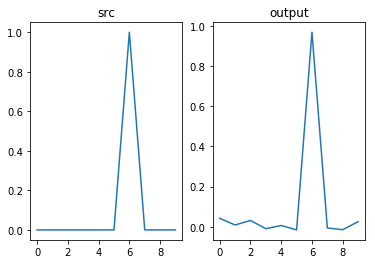

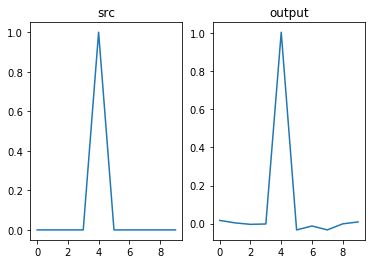

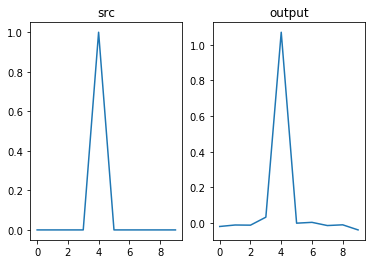

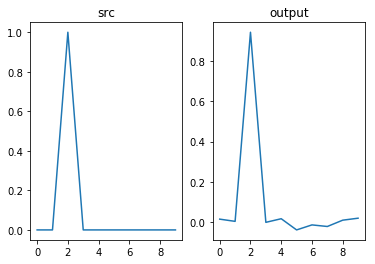

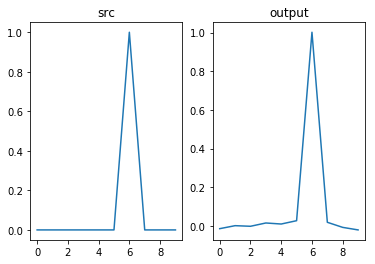

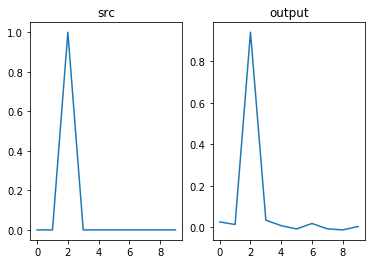

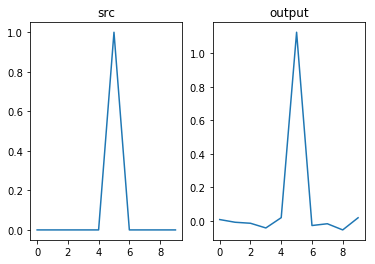

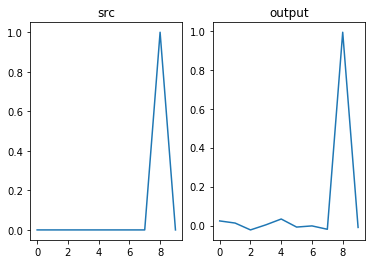

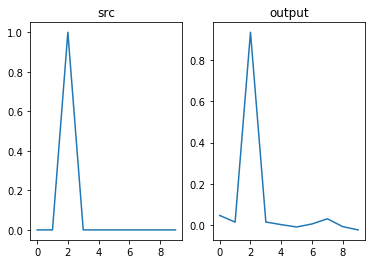

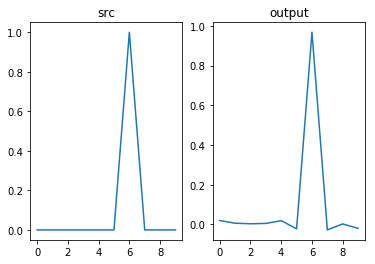

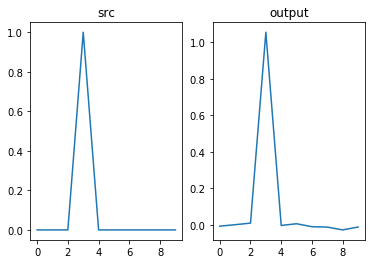

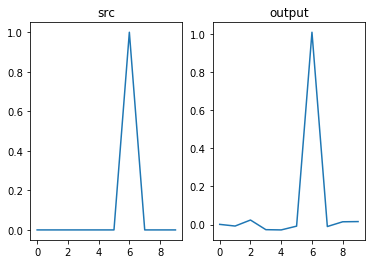

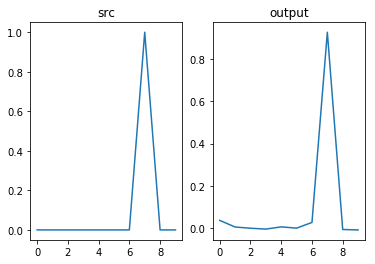

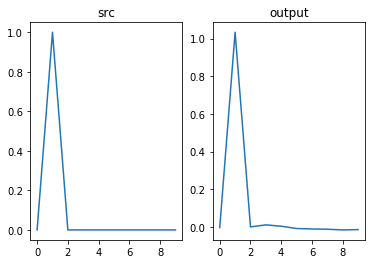

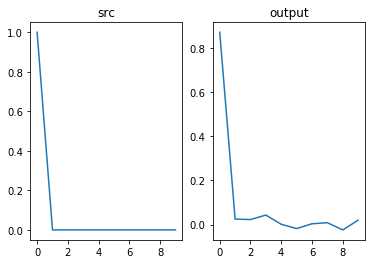

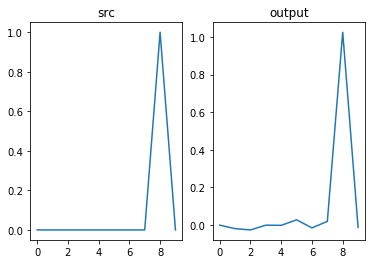

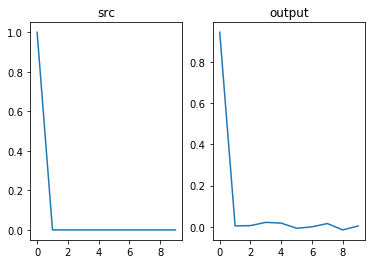

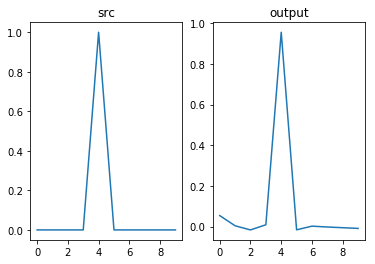

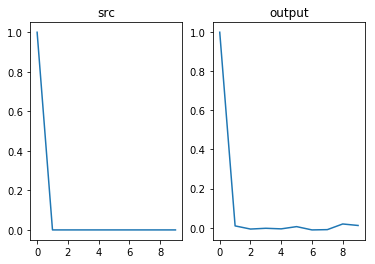

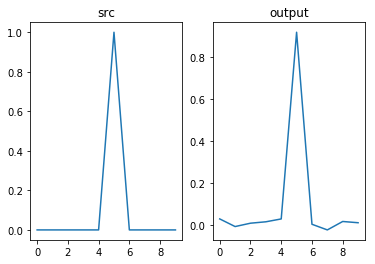

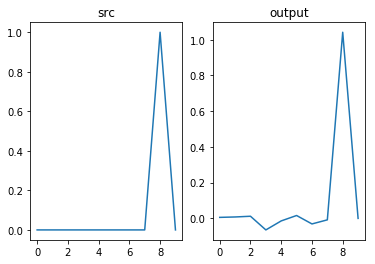

In [17]:
test(print_results = not test_is_image)
graphical_test()